# 🧪 NMR Deep Learning Enhancement Project 🚀

## ✅ Goals & To-Dos

1. **Prepare FID Data** 📊  
   - Load raw FID using `nmr.load_fid_and_preview`  
   - Normalize and format for PyTorch `(batch, 1, length)`  

2. **Build DL Model** 🤖  
   - 1D Convolutional Autoencoder or Dilated Conv Network  
   - Input: raw FID  
   - Output: enhanced / denoised FID  

3. **Train Model** 🏋️‍♂️  
   - Start with **simulated FIDs** (damped sinusoids + noise)  
   - Later fine-tune on **experimental FIDs**  

4. **Integrate With Existing Pipeline** 🔗  
   - Feed `enhanced_FID` into `compute_fft_spectrum`  
   - Run peak detection, integration, and J-coupling analysis as usual  

5. **Compare Results** 📈  
   - Original vs enhanced FID → FFT → peaks → integrals  
   - Evaluate **noise reduction, peak clarity, and acquisition efficiency**  

6. **Optional Advanced Steps** ✨  
   - End-to-end model: partial FID → predicted spectrum  
   - Explore **super-resolution/extrapolation** to reduce acquisition time  

---

💡 **Tip:** Keep the DL module modular so it can be swapped in/out without breaking existing code.  

| Goal                   | What to Do                                                    |
| ---------------------- | ------------------------------------------------------------- |
| Prevent over-smoothing | Add L1 term to loss; raise frequency weight                   |
| Match real stats       | Add correlated complex noise + polynomial baselines           |
| Teach confidence       | Replace last Conv1d with BayesianTorch layer                  |
| Fine-tune realism      | Convert 10–20 real FIDs → `.asc` → arrays → 1–3 epochs low-LR |
| Quantify success       | Track ΔSNR, FFT correlation, and residual histograms          |


In [4]:
# --- Environment & Imports ---
import os, glob, math, time, numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt, pandas as pd
from importlib import reload

In [ ]:
# Make sure working directory and imports are correct
# os.chdir is used in this script to change the current working directory to the specified path which in our case is "C:\Users\Windows User\NMR-Project".
#this is just us bringing in our functions from the functions folder
os.chdir(r"C:\Users\Windows User\NMR-Project")  # adjust if needed
import functions.nmr_function as nmr

# --- Checkpoint setup ---
# We define the directory where model checkpoints are stored and the path to the latest checkpoint file.
#so it basically saves our previously trained model here
CHECKPOINT_DIR = os.path.join(os.getcwd(), "checkpoints")
LATEST = os.path.join(CHECKPOINT_DIR, "DenoiseNetPhysics_latest.pth")

## At the moment it instantiates _Identity first, then loads weights (which will fail if weights belong to DenoiseNetPhysics). Better: instantiate DenoiseNetPhysics before loading

In [14]:
# --- Model handling ---
_using_identity = False

class _Identity(nn.Module):
    def forward(self, x):
        return x  # pass-through

if 'model_physics' not in globals():
    if os.path.exists(LATEST):
        try:
            # Try to build real model then load checkpoint
            model_physics = DenoiseNetPhysics().to(torch.device('cpu'))
            ckpt = torch.load(LATEST, map_location='cpu')
            state = ckpt.get('model_state', ckpt)  # handle raw state_dict vs wrapped
            model_physics.load_state_dict(state)
            print(f"[Info] Loaded checkpoint into {model_physics.__class__.__name__}.")
        except Exception as e:
            model_physics = _Identity()
            _using_identity = True
            print(f"[Warn] Failed to load checkpoint; using identity. {e}")
    else:
        model_physics = _Identity()
        _using_identity = True
        print("[Info] No checkpoint found. Using identity model.")

print(f"Model architecture: {model_physics.__class__.__name__} (identity={_using_identity}) {model_physics}")

Model architecture: DenoiseNetPhysics (identity=False) DenoiseNetPhysics(
  (inp): Conv1d(2, 64, kernel_size=(11,), stride=(1,), padding=(5,))
  (blocks): Sequential(
    (0): DilatedResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,))
    )
    (1): DilatedResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(10,), dilation=(2,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(10,), dilation=(2,))
    )
    (2): DilatedResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(20,), dilation=(4,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(20,), dilation=(4,))
    )
    (3): DilatedResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(40,), dilation=(8,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(40,), dilation=(8,))
    )
 

#### once we get an external gpu we can convert this cell here to use a cuda gpu instead
change the location of where the model is stored

Pros (cpu): Always available, simpler debugging (can print tensors without transfers), deterministic behavior more often, no GPU memory management issues. Cons (cpu): Much slower training/inference for convolutional networks, limited parallelism, impractical for longer curricula or large datasets.

In [ ]:
# --- Device check ---
#this function checks which device (CPU or GPU) the model is using for computations.
def _model_device(mp):
    try:
        p = next(mp.parameters())
        return p.device
    except Exception:
        return torch.device('cpu')
device = _model_device(model_physics)
print(f"Using device: {device}")

Using device: cpu


In [17]:
# --- Config ---
#this is just the data directory where our training data is stored
#save_outputs is a boolean flag that determines whether to save the denoised output files or not. we can convert it to true once the model is working properly
# out_dir is the directory where denoised output files will be saved if save_outputs is set to True.

data_dir = r"C:\Users\Windows User\NMR-Project\training_data"
save_outputs = False  # set True to write denoised .asc files
out_dir = os.path.join(data_dir, "denoised")
if save_outputs:
    os.makedirs(out_dir, exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Output directory: {out_dir} (save_outputs={save_outputs})")

Data directory: C:\Users\Windows User\NMR-Project\training_data
Output directory: C:\Users\Windows User\NMR-Project\training_data\denoised (save_outputs=False)


In [ ]:
# --- Collect files ---
#this part of the code is responsible for gathering all the .asc files from the specified data directory for processing.
files = sorted(glob.glob(os.path.join(data_dir, "*.asc")))
if not files:
    raise FileNotFoundError(f"No .asc files found in {data_dir}")
print(f"Found {len(files)} .asc files in {data_dir}")
if _using_identity:
    print("Note: Using identity model. ΔSNR will be ~0 (preview only).")

In [ ]:
# --- Helper functions ---
def _read_asc(path):
    arr = np.genfromtxt(path, delimiter=None)
    if arr.ndim == 1: arr = arr.reshape(-1, 1)
    if arr.shape[1] == 1:
        r, im = arr[:, 0].astype(float), np.zeros_like(arr[:, 0])
        t = np.arange(len(r), dtype=float)
    else:
        t, r = arr[:, 0], arr[:, 1]
        im = arr[:, 2] if arr.shape[1] >= 3 else np.zeros_like(r)
    m = np.isfinite(t) & np.isfinite(r) & np.isfinite(im)
    t, r, im = t[m], r[m], im[m]
    if t.size >= 2 and t[1] < t[0]:
        idx = np.argsort(t)
        t, r, im = t[idx], r[idx], im[idx]
    return t, r, im

def _preprocess_pair(real_imag_2xL: np.ndarray, max_gain=1e3):
    sig = real_imag_2xL.copy().astype(float)
    L = sig.shape[1]
    tail = slice(int(0.8 * L), L)
    baseline = sig[:, tail].mean(axis=1, keepdims=True)
    sig -= baseline
    tail_rms = np.sqrt((sig[:, tail] ** 2).mean(axis=1, keepdims=True) + 1e-12)
    tiny = tail_rms < 1e-6
    if np.any(tiny):
        half = slice(int(0.5 * L), L)
        alt_rms = np.sqrt((sig[:, half] ** 2).mean(axis=1, keepdims=True) + 1e-12)
        tail_rms = np.where(tiny, alt_rms, tail_rms)
    gain = np.minimum(1.0 / (tail_rms + 1e-12), max_gain)
    return sig * gain

def _denoise(sig_2xL: np.ndarray):
    mp = model_physics
    mp.eval()
    with torch.no_grad():
        x = torch.from_numpy(sig_2xL).unsqueeze(0).to(device)
        y = mp(x).detach().cpu().squeeze(0).numpy()
    return y

def _head_print(t, r, im, rows=8, label=None):
    df = pd.DataFrame({"time_s": t[:rows], "real": r[:rows], "imag": im[:rows]})
    if label: print(f"\n{label}")
    print(df.to_string(index=False))

def _snr_from_env(env):
    L = env.shape[0]
    s0, s1, n0, n1 = 0, int(0.2*L), int(0.8*L), L
    sig_rms = np.sqrt(np.mean(env[s0:s1]**2))
    noise_rms = np.sqrt(np.mean(env[n0:n1]**2))
    return 20*np.log10(sig_rms/(noise_rms+1e-12))

def _robust_dt(t):
    d = np.diff(t)
    d = d[np.isfinite(d) & (d > 0)]
    return float(np.median(d)) if d.size else np.nan

@torch.no_grad()
def _estimate_t2_from_pair(pair_2xL, dt, frac=0.25):
    z = torch.from_numpy(pair_2xL)
    r, i = z[0], z[1]
    env = torch.clamp(torch.sqrt(r*r + i*i), min=1e-12)
    n = max(16, int(frac * env.shape[-1]))
    tvec = torch.arange(n, dtype=env.dtype) * dt
    y = torch.log(env[:n])
    A = torch.stack([torch.ones_like(tvec), tvec], dim=1)
    sol = torch.linalg.lstsq(A, y.unsqueeze(1)).solution
    b = float(sol[1])
    return float((-1.0 / b) if b < 0 else (0.2 * n * dt))


Found 27 .asc files in C:\Users\Windows User\NMR-Project\training_data

Head → 13_03_11_indst_1H%20fid.asc
  time_s      real      imag
0.000000  0.000003  0.000009
0.000133 -0.001235 -0.003140
0.000267  0.050601  0.188029
0.000400  0.019175  0.365893
0.000533 -0.136525 -0.611649
0.000666  0.256887  0.373811
0.000800 -0.284701 -1.050071
0.000933  0.295897  0.892038
Metrics → MSE=0.000e+00 | SNR orig=24.26 dB | den=24.26 dB | Δ=0.00 dB


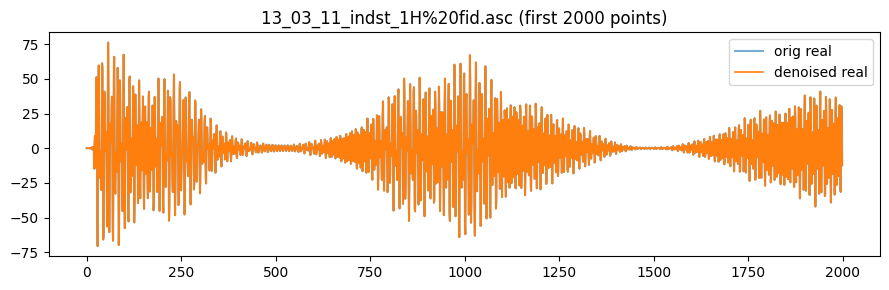


Head → training_data_1.asc
   time_s      real      imag
-2.506402  0.000239 -0.000347
-2.505256 -0.000096 -0.000442
-2.504111  0.000151 -0.000326
-2.502965  0.000271 -0.000359
-2.501820  0.000169 -0.000273
-2.500674  0.000190 -0.000206
-2.499529  0.000040 -0.000213
-2.498383  0.000298 -0.000217
Metrics → MSE=0.000e+00 | SNR orig=8.99 dB | den=8.99 dB | Δ=0.00 dB


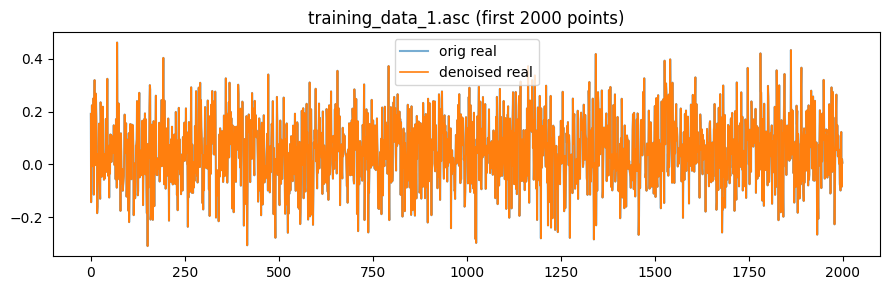


Head → training_data_10.asc
    time_s     real      imag
-24.960219 0.000298  0.000497
-24.950684 0.000636 -0.000015
-24.941150 0.000882  0.000159
-24.931615 0.000667  0.000683
-24.922081 0.000494  0.000222
-24.912546 0.000658  0.000223
-24.903011 0.001162  0.000363
-24.893477 0.001101  0.001547
Metrics → MSE=0.000e+00 | SNR orig=12.29 dB | den=12.29 dB | Δ=0.00 dB


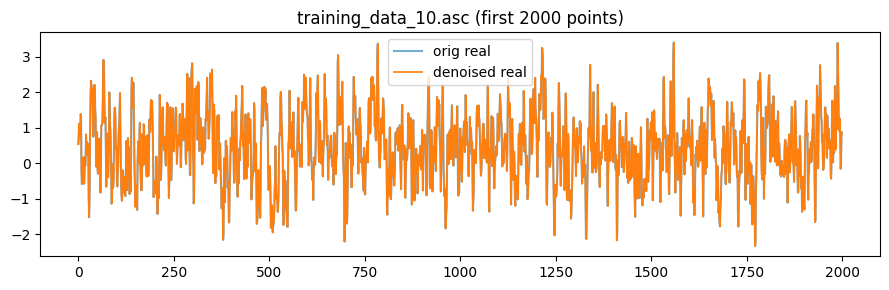


Head → training_data_11.asc
    time_s      real      imag
-24.960219 -0.000707 -0.005553
-24.950684 -0.000659 -0.006422
-24.941150  0.001306 -0.007432
-24.931615  0.004766 -0.006269
-24.922081  0.005264 -0.002406
-24.912546  0.003022 -0.000512
-24.903011  0.001504 -0.001131
-24.893477  0.000707 -0.001353
Metrics → MSE=0.000e+00 | SNR orig=5.12 dB | den=5.12 dB | Δ=0.00 dB


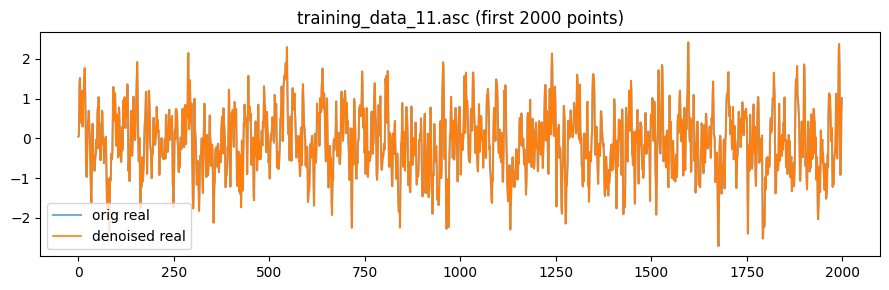


Head → training_data_12.asc
  time_s      real      imag
0.000000  0.000001  0.000013
0.000133 -0.001206 -0.004204
0.000267 -0.015305  0.264425
0.000400 -0.393098  0.597293
0.000533 -0.390635 -0.655285
0.000666 -0.159620  0.535001
0.000800 -0.119189 -1.585681
0.000933  0.777831  0.917124
Metrics → MSE=0.000e+00 | SNR orig=55.98 dB | den=55.98 dB | Δ=0.00 dB


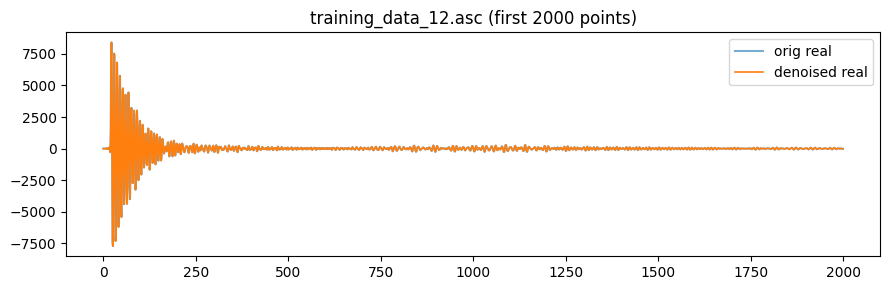


--- Summary ---
                       file     N        dt_s  nyquist_hz  nyquist_ppm     T2_s  ΔSNR_dB
13_03_11_indst_1H%20fid.asc 16384  0.00013328      3751.5      9.37875  3.84907        0
        training_data_1.asc 13107  0.00114549     436.494      1.09124 0.750526        0
       training_data_10.asc 26214  0.00953458     52.4407     0.131102   12.496        0
       training_data_11.asc 26214  0.00953458     52.4407     0.131102   12.496        0
       training_data_12.asc 16384  0.00013328      3751.5      9.37875 0.233396        0
       training_data_13.asc 13107  0.00114549     436.494      1.09124  114.805        0
       training_data_14.asc 13107  0.00114549     436.494      1.09124 0.750526        0
       training_data_15.asc 13107  0.00114549     436.494      1.09124 0.750526        0
       training_data_16.asc 13107  0.00114549     436.494      1.09124 0.750526        0
       training_data_17.asc 13107  0.00114549     436.494      1.09124 0.750526        0
    

In [ ]:

# --- Main Loop ---
rows, previewed, improved, processed, saved = [], 0, 0, 0, 0
max_preview = 5
nu0_Hz = 400e6  # adjust for your NMR frequency if needed

for fpath in files:
    fname = os.path.basename(fpath)
    try:
        t, r, im = _read_asc(fpath)
        pair = np.stack([r, im])
        sig = _preprocess_pair(pair)
        den = _denoise(sig)
        env_x, env_y = np.sqrt(sig[0]**2 + sig[1]**2), np.sqrt(den[0]**2 + den[1]**2)
        mse = float(np.mean((den - sig)**2))
        snr_x, snr_y = _snr_from_env(env_x), _snr_from_env(env_y)
        dsnr = snr_y - snr_x
        dt_i = _robust_dt(t)
        nyq_hz = (1.0 / (2.0 * dt_i)) if np.isfinite(dt_i) and dt_i > 0 else np.nan
        nyq_ppm = nyq_hz / (nu0_Hz / 1e6)
        T2_i = _estimate_t2_from_pair(sig, dt_i if np.isfinite(dt_i) else 1.0)

        if dsnr > 0.5: improved += 1
        if previewed < max_preview:
            _head_print(t, r, im, label=f"Head → {fname}")
            print(f"Metrics → MSE={mse:.3e} | SNR orig={snr_x:.2f} dB | den={snr_y:.2f} dB | Δ={dsnr:.2f} dB")
            early = min(2000, sig.shape[1])
            plt.figure(figsize=(9,3))
            plt.plot(np.arange(early), sig[0,:early], label='orig real', alpha=0.6)
            plt.plot(np.arange(early), den[0,:early], label='denoised real', lw=1.2)
            plt.legend(); plt.title(f"{fname} (first {early} points)"); plt.tight_layout(); plt.show()
            previewed += 1

        if save_outputs:
            out_path = os.path.join(out_dir, os.path.splitext(fname)[0] + "_denoised.asc")
            np.savetxt(out_path, np.column_stack([t, den[0], den[1]]),
                       fmt="%.9g", header="time_s real imag", comments="")
            saved += 1

        rows.append({"file": fname, "N": sig.shape[1], "dt_s": dt_i,
                     "nyquist_hz": nyq_hz, "nyquist_ppm": nyq_ppm,
                     "T2_s": T2_i, "ΔSNR_dB": dsnr})
        processed += 1

    except Exception as e:
        print(f"[Skip] {fname}: {e}")
        continue

summary_df = pd.DataFrame(rows)
print("\n--- Summary ---")
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.6g}"))
print(f"\nProcessed: {processed} | Previewed: {previewed} | Improved ΔSNR>0.5: {improved} | Saved: {saved}")


In [7]:
# ---- 0) Device + AMP ----
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
try:
    torch.set_float32_matmul_precision('high')
except Exception:
    pass
if use_cuda:
    torch.backends.cudnn.benchmark = True
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler(enabled=True)
else:
    from contextlib import nullcontext
    autocast = lambda enabled=False: nullcontext()
    class _Noop:
        def scale(self, x): return x
        def step(self, opt): opt.step()
        def update(self): pass
    scaler = _Noop()


c:\Users\Windows User\NMR-Project\.venv\Lib\site-packages\torch\__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  _C._set_float32_matmul_precision(precision)


In [8]:
# Real-data preprocessing: baseline removal + tail RMS scaling (preserves noise scale)
import numpy as np, torch, os, glob

# Ensure device exists (fallback cpu if this cell is run before device cell)
try:
    device
except NameError:
    device = torch.device('cpu')

MAX_GAIN = 1e3  # cap normalization gain to avoid explosions

# Ensure we have a `data`/`pair` to build `sig`; if not, read the first file from data_dir using shared _read_asc
if 'sig' not in globals():
    if 'pair' in globals():
        tmp_pair = pair
    elif 'data' in globals():
        arr = np.asarray(data)
        if arr.ndim == 2 and arr.shape[1] >= 2:
            r = arr[:, 1].astype(float)
            im = arr[:, 2].astype(float) if arr.shape[1] >= 3 else np.zeros_like(r)
            tmp_pair = np.stack([r, im])
        else:
            raise ValueError("`data` is not shaped like (N,>=2). Can't construct [real, imag].")
    else:
        # Fallback: read first .asc using utilities; if missing, define defaults here
        if 'data_dir' not in globals():
            data_dir = r"C:\Users\Windows User\NMR-Project\training_data"
        if '_read_asc' not in globals():
            def _read_asc(path):
                arr = np.genfromtxt(path, delimiter=None)
                if arr is None or arr.size == 0:
                    raise ValueError(f"Empty data in {path}")
                if arr.ndim == 1:
                    arr = arr.reshape(-1, 1)
                if arr.shape[1] == 1:
                    r = arr[:, 0].astype(float)
                    im = np.zeros_like(r)
                    t = np.arange(len(r), dtype=float)
                else:
                    t = arr[:, 0].astype(float)
                    r = arr[:, 1].astype(float)
                    im = (arr[:, 2].astype(float) if arr.shape[1] >= 3 else np.zeros_like(r))
                m = np.isfinite(t) & np.isfinite(r) & np.isfinite(im)
                t, r, im = t[m], r[m], im[m]
                if t.size >= 2 and t[1] < t[0]:
                    idx = np.argsort(t)
                    t, r, im = t[idx], r[idx], im[idx]
                return t, r, im
        files_fallback = sorted(glob.glob(os.path.join(data_dir, "*.asc")))
        if not files_fallback:
            raise FileNotFoundError(f"No .asc files found in {data_dir}")
        t_fb, r_fb, im_fb = _read_asc(files_fallback[0])
        data = np.column_stack([t_fb, r_fb, im_fb])
        tmp_pair = np.stack([r_fb, im_fb])
        # derive dt from fallback
        if 'dt' not in globals():
            dt = float(t_fb[1] - t_fb[0]) if t_fb.size >= 2 else 1.0
    L = tmp_pair.shape[1]
    tail = slice(int(0.8 * L), L)
    baseline = tmp_pair[:, tail].mean(axis=1, keepdims=True)
    sig = tmp_pair - baseline
    # Robust tail RMS scaling with cap
    tail_rms = np.sqrt((sig[:, tail] ** 2).mean(axis=1, keepdims=True) + 1e-12)
    tiny = tail_rms < 1e-6
    if np.any(tiny):
        half = slice(int(0.5 * L), L)
        alt_rms = np.sqrt((sig[:, half] ** 2).mean(axis=1, keepdims=True) + 1e-12)
        tail_rms = np.where(tiny, alt_rms, tail_rms)
    gain = 1.0 / (tail_rms + 1e-12)
    gain = np.minimum(gain, MAX_GAIN)
    sig = sig * gain
else:
    L = sig.shape[1]

# Build torch tensor on the chosen device (float32)
fid_tensor = torch.from_numpy(sig).float().unsqueeze(0).to(device)  # (1,2,L)

# ---- 2) Physics params + T2 estimate prerequisites ----
if 'dt' not in globals():
    # derive from `data` if possible
    if 'data' in globals() and np.asarray(data).shape[0] >= 2:
        dt = float(data[1, 0] - data[0, 0])
    else:
        dt = 1.0

gamma_Hz_per_T = 42.57747892e6       # 1H gyromagnetic ratio (Hz/T)

# Set spectrometer frequency directly (Hz)
nu0_Hz = 399.78219838e6              # 399.78219838 MHz
nu0_MHz = nu0_Hz / 1e6

nyquist_hz = 1.0 / (2.0 * dt)
nyquist_ppm = nyquist_hz / nu0_MHz

In [10]:
# Model instantiation + training hyperparameters + checkpoint config
import os, time, math, torch
from datetime import datetime

MODEL_NAME = "DenoiseNetPhysics"
CHECKPOINT_DIR = os.path.join(os.getcwd(), "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

model_physics = DenoiseNetPhysics().apply(_init_weights).to(device)
opt = torch.optim.Adam(model_physics.parameters(), lr=8e-4, weight_decay=1e-4)

# Optionally load latest checkpoint if present
latest_path = os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_latest.pth")
if os.path.exists(latest_path):
    try:
        state = torch.load(latest_path, map_location=device)
        model_physics.load_state_dict(state['model_state'])
        print(f"Loaded checkpoint: {latest_path}")
    except Exception as e:
        print("Could not load checkpoint:", e)

# ---- 6) Curriculum training with combined_loss ----
EPOCHS = 6                 # increased epochs
STEPS_PER_EPOCH = 40
BATCH_SIZE = 8
CROP_LEN = 2048
NOISE_SCHEDULE = [0.04, 0.035, 0.03, 0.03, 0.025, 0.025]  # per-epoch noise (post tail-RMS scale)

# Real-data fine-tune on all .asc files (self-denoising)
REAL_FINETUNE_EPOCHS = 1   # set >=1 to use all training_data
REAL_BATCH_SIZE = 8

Loaded checkpoint: C:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth



Training with combined loss (synthetic curriculum)...
epoch 1: train_loss=0.000919 | val base=0.000312 model=0.000312 ΔSNR=-0.01 dB
epoch 2: train_loss=0.000615 | val base=0.000312 model=0.000314 ΔSNR=-0.03 dB
epoch 3: train_loss=0.000472 | val base=0.000312 model=0.000322 ΔSNR=-0.13 dB
epoch 4: train_loss=0.000460 | val base=0.000313 model=0.000315 ΔSNR=-0.03 dB
epoch 5: train_loss=0.000317 | val base=0.000312 model=0.000322 ΔSNR=-0.14 dB
epoch 6: train_loss=0.000304 | val base=0.000311 model=0.000320 ΔSNR=-0.12 dB
synthetic train time: 288.4s

Fine-tuning on real .asc files (self-denoising across entire training_data)...
real ft epoch 1: loss=0.024455 over 27 files
Saved checkpoints → C:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_20251110_145921.pth and C:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth

Overfitting single real FID (sanity check)...
step 50: loss=1.613426e-08
step 100: loss=1.198472e-10
step 150: loss=4.661558e-11
step 200: 

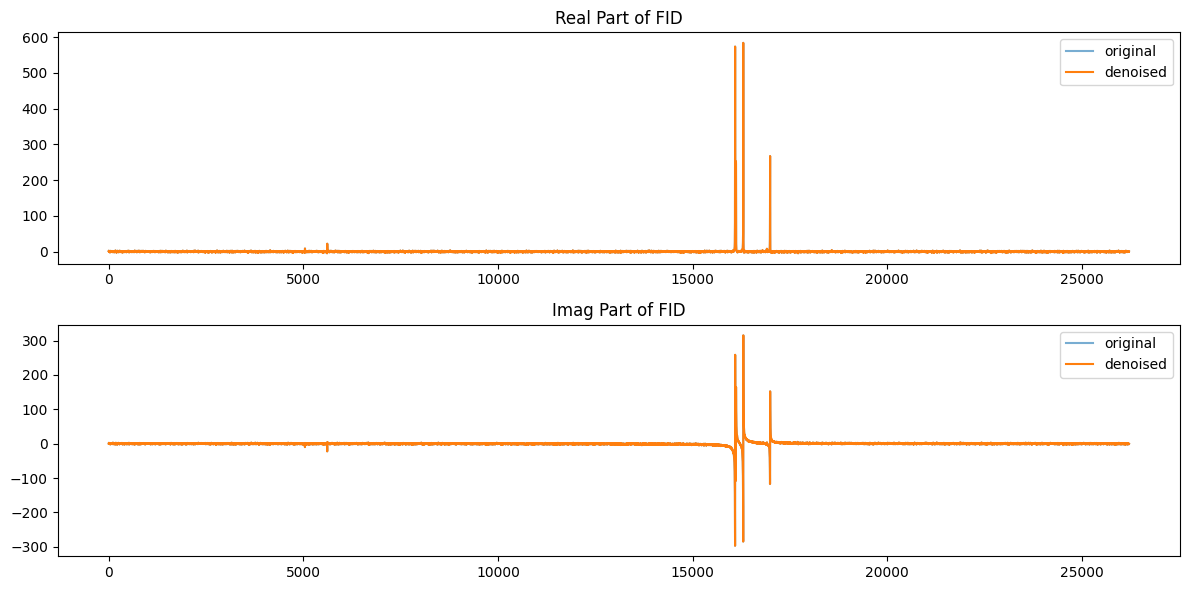

Done. Trained, fine-tuned on all training_data files, saved checkpoints, overfit sanity check, and plotted results.


In [11]:
# Training: synthetic curriculum → (optional) real-data fine-tune over ALL .asc files → save checkpoints
import os, glob, numpy as np, torch, math, time
from datetime import datetime

print("\nTraining with combined loss (synthetic curriculum)...")
t0 = time.perf_counter()
for ep in range(EPOCHS):
    model_physics.train()
    running = 0.0
    sn = NOISE_SCHEDULE[min(ep, len(NOISE_SCHEDULE) - 1)]
    for _ in range(STEPS_PER_EPOCH):
        x, y = synth_batch_phys(batch_size=BATCH_SIZE, L=CROP_LEN, snr_std=sn, colored_noise=True)
        opt.zero_grad(set_to_none=True)
        with autocast(enabled=use_cuda):
            pred = model_physics(x)
            loss = combined_loss(pred, y, dt=dt, x_ref=x)
        loss.backward()  # use standard backward to allow grad clipping on CPU
        torch.nn.utils.clip_grad_norm_(model_physics.parameters(), max_norm=1.0)
        opt.step()
        running += float(loss.detach())

    # Validation snapshot vs baseline at target noise
    model_physics.eval()
    with torch.no_grad():
        xv, yv = synth_batch_phys(batch_size=64, L=CROP_LEN, snr_std=NOISE_SCHEDULE[-1], colored_noise=True)
        with autocast(enabled=use_cuda):
            pv = model_physics(xv)
        mse_noisy = torch.mean((xv - yv) ** 2).item()
        mse_pred = torch.mean((pv - yv) ** 2).item()
        snr_impr_db = 20 * math.log10((mse_noisy ** 0.5) / max(mse_pred ** 0.5, 1e-12))
    print(f"epoch {ep+1}: train_loss={running/STEPS_PER_EPOCH:.6f} | val base={mse_noisy:.6f} model={mse_pred:.6f} ΔSNR={snr_impr_db:.2f} dB")

print(f"synthetic train time: {time.perf_counter()-t0:.1f}s")

# ---- Real-data fine-tune on ALL .asc files in training_data (self-denoising) ----
if REAL_FINETUNE_EPOCHS > 0:
    print("\nFine-tuning on real .asc files (self-denoising across entire training_data)...")
    files_ft = sorted(glob.glob(os.path.join(data_dir, "*.asc")))
    # Temporarily lower LR for stability on real data
    old_lr = opt.param_groups[0]['lr']
    for g in opt.param_groups:
        g['lr'] = min(old_lr, 2e-4)
    for ep in range(REAL_FINETUNE_EPOCHS):
        model_physics.train()
        total = 0.0; count = 0
        for f in files_ft:
            t_r, r_r, i_r = _read_asc(f)
            pair = np.stack([r_r, i_r])
            sig_np = _preprocess_pair(pair, max_gain=1e3)  # (2, L) with robust scaling
            x_real = torch.from_numpy(sig_np).float().unsqueeze(0).to(device)
            y_real = x_real  # self-denoising target
            opt.zero_grad(set_to_none=True)
            with autocast(enabled=use_cuda):
                pred = model_physics(x_real)
                loss = combined_loss(pred, y_real, dt=dt, x_ref=x_real)
            # Skip if unstable
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"[Skip unstable] {os.path.basename(f)} loss=NaN/Inf")
                continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_physics.parameters(), max_norm=1.0)
            opt.step()
            total += float(loss.detach()); count += 1
        print(f"real ft epoch {ep+1}: loss={total/max(1,count):.6f} over {count} files")
    # Restore LR
    for g in opt.param_groups:
        g['lr'] = old_lr

# ---- Save checkpoints ----
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
ckpt_path = os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_{stamp}.pth")
latest_path = os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_latest.pth")
torch.save({'model_state': model_physics.state_dict(), 'config': {
    'EPOCHS': EPOCHS, 'STEPS_PER_EPOCH': STEPS_PER_EPOCH, 'BATCH_SIZE': BATCH_SIZE, 'CROP_LEN': CROP_LEN,
    'NOISE_SCHEDULE': NOISE_SCHEDULE, 'REAL_FINETUNE_EPOCHS': REAL_FINETUNE_EPOCHS
}}, ckpt_path)
torch.save({'model_state': model_physics.state_dict()}, latest_path)
print(f"Saved checkpoints → {ckpt_path} and {latest_path}")

# ---- Overfit a single real FID (sanity check) ----
print("\nOverfitting single real FID (sanity check)...")
model_physics.train()
x_real = fid_tensor.clone()  # (1,2,L)
y_real = x_real.clone()
opt_overfit = torch.optim.Adam(model_physics.parameters(), lr=1e-3)
for i in range(200):
    opt_overfit.zero_grad(set_to_none=True)
    with autocast(enabled=use_cuda):
        pred = model_physics(x_real)
        loss = combined_loss(pred, y_real, dt=dt, x_ref=x_real)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model_physics.parameters(), max_norm=1.0)
    opt_overfit.step()
    if (i + 1) % 50 == 0:
        print(f"step {i+1}: loss={float(loss.detach()):.6e}")

# ---- Inference on real FID + plots ----
model_physics.eval()
with torch.no_grad():
    with autocast(enabled=use_cuda):
        denoised = model_physics(fid_tensor).cpu()  # (1,2,L)

print("\nShapes → input:", tuple(fid_tensor.shape), "denoised:", tuple(denoised.shape))

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title("Real Part of FID")
plt.plot(fid_tensor[0, 0].detach().cpu().numpy(), label="original", alpha=0.6)
plt.plot(denoised[0, 0].detach().cpu().numpy(), label="denoised", lw=1.5)
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Imag Part of FID")
plt.plot(fid_tensor[0, 1].detach().cpu().numpy(), label="original", alpha=0.6)
plt.plot(denoised[0, 1].detach().cpu().numpy(), label="denoised", lw=1.5)
plt.legend()
plt.tight_layout()
plt.show()

print("Done. Trained, fine-tuned on all training_data files, saved checkpoints, overfit sanity check, and plotted results.")

### Once me and Krish get a spectrum replace this with that FID

Make the FID into a torch instead of a numpy array so that now You can put it into pytorch.

The output says that we are processing 1 FID, we are working with 2 chanels (real vs imaginary) , and the length of that is x (depending on the particular FID)

#### use a bayesian torch here
would using a bayesian model help with the MRSE calcs?

# 🧠 Understanding the Dilated Conv FID Network

## 1️⃣ Parameters (Weights & Biases)

For a Conv1D layer:

$$
\text{Weights shape: } (C_{\text{out}}, C_{\text{in}}, K)
$$

- $C_{\text{in}}$ = input channels  
- $C_{\text{out}}$ = output channels  
- $K$ = kernel size  

**Number of weight parameters:**
$$
N_{\text{weights}} = C_{\text{out}} \times C_{\text{in}} \times K
$$

**Number of bias parameters:**
$$
N_{\text{bias}} =
\begin{cases}
C_{\text{out}} & \text{if bias exists} \\
0 & \text{otherwise}
\end{cases}
$$

**Total parameters per layer:**
$$
N_{\text{params}} = N_{\text{weights}} + N_{\text{bias}}
$$

> Example: First Conv1D: `(32, 2, 7)` → $(32 \times 2 \times 7 = 448)$ weights + 32 biases → 480 total params

---

## 2️⃣ Kernel Intuition

- Kernel = small 1D array of trainable numbers  
- Slides along FID → multiplies & sums → extracts local patterns (peaks, oscillations)  
- Each output channel has its own kernel for every input channel

---

## 3️⃣ Choosing Channels

- Input channels: $C_{\text{in}} = 2$ (Real + Imag FID)  
- Hidden channels: $C_{\text{hidden}} = 32$ (network capacity hyperparameter)  
- Output channels: same as input ($C_{\text{out}} = 2$)  

---

## 4️⃣ Dilation & Effective Kernel

**Dilation** = spacing between kernel elements:

$$
\text{Effective kernel size: } K_{\text{eff}} = D \cdot (K - 1) + 1
$$

- $D$ = dilation factor  
- $K_{\text{eff}}$ = how many original FID points a single output “sees”  
- Cumulative receptive field adds contributions from each layer:  

$$
\text{cum\_RF}_{i} = \text{cum\_RF}_{i-1} + K_{\text{eff}} - 1
$$

> Your network final layer sees 385 points of the original FID.

---

## 5️⃣ Residual Connections

- Each `DilatedResBlock` predicts a **residual**:  

$$
\text{output} = x + \text{residual}(x)
$$

- Helps learning: network focuses on **correcting noise** rather than recreating FID from scratch

---

## 6️⃣ Visual Intuition

- Input: FID `(batch, channels, length)`  
- Layers: conv1 → residual blocks → out  
- Each block expands **receptive field** via dilation  
- Visual: each ■ = output channel  